In [37]:
import os
import pickle
import pandas as pd

def load_metadata(directory):
    metadata = []
    for file_name in os.listdir(directory):
        if file_name.endswith('meta.pkl'):
            with open(os.path.join(directory, file_name), 'rb') as f:
                data = pickle.load(f)
                metadata.append({
                    'file_name': file_name,
                    'hyperparameter': data['hyperparameter'],
                    'profit': data['profit'],
                    'elapsed_time': data['elapsed_time'],
                    'peak_memory' : data['peak_memory'],
                    'avg_memory': data['avg_memory']
                })
    return metadata

# Directory where the test files are located
directory_path = 'C:/Users/lanza/Master_Thesis_EL/Integrated-vs-Seperated-Master-Thesis/hpc_mount/'

# Load metadata from all models
metadata_list = load_metadata(directory_path)

# Convert to DataFrame for better visualization
df_metadata = pd.DataFrame(metadata_list)



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\4239388038.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\4239388038.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


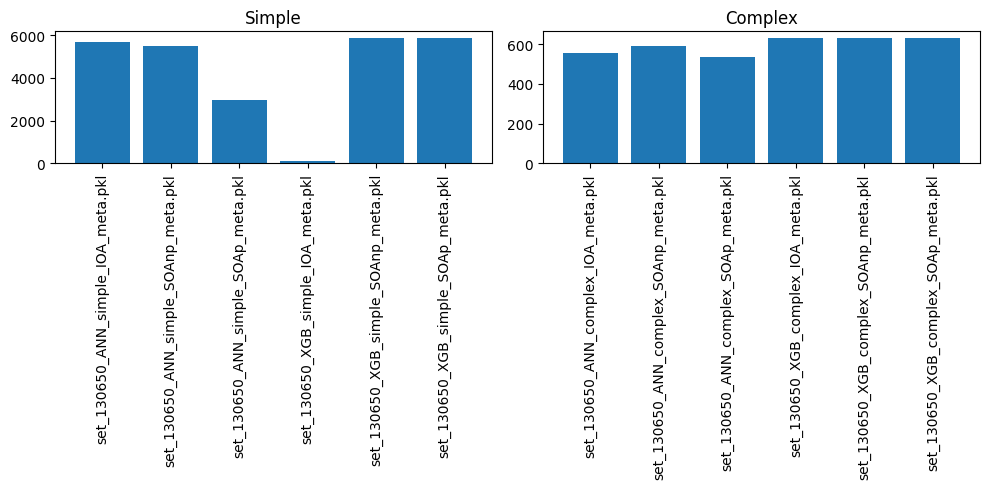

In [38]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('130650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('130650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['profit'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['profit'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\3625571128.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability


C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\3625571128.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


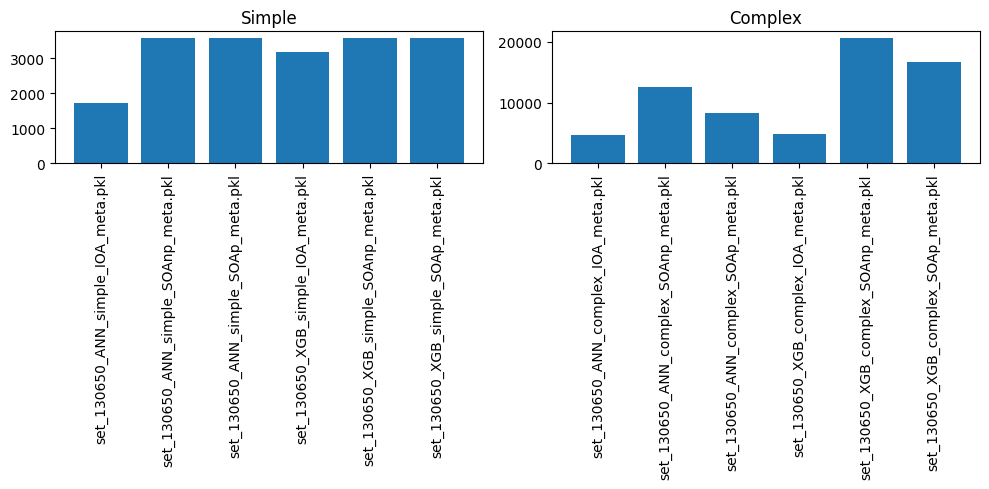

In [39]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('130650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('130650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['avg_memory'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['avg_memory'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2084475015.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2084475015.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


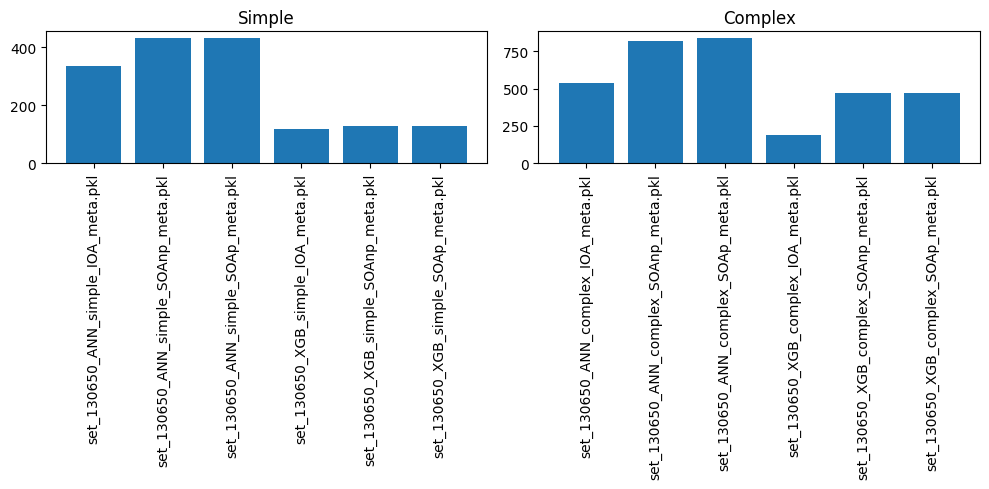

In [40]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('130650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('130650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['elapsed_time'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['elapsed_time'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\479821644.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\479821644.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


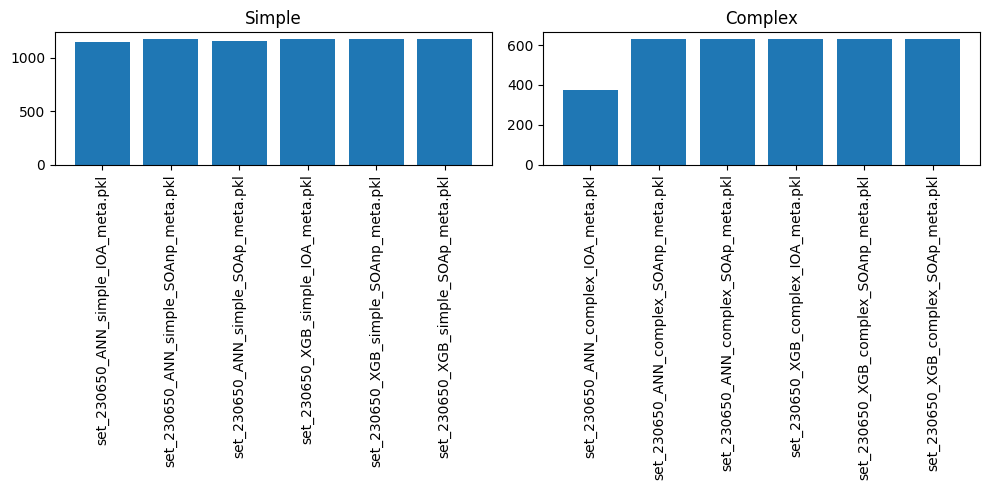

In [41]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('230650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('230650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['profit'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['profit'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\249931662.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\249931662.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


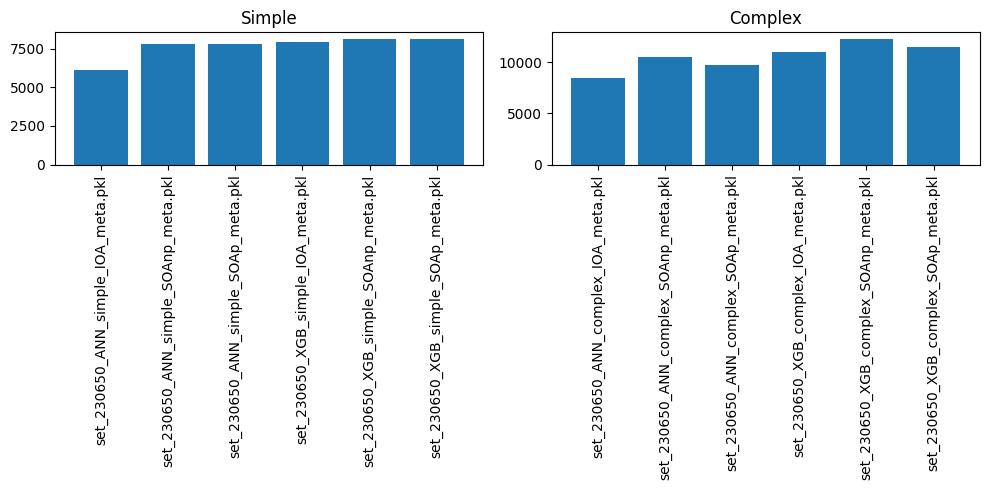

In [42]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('230650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('230650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['avg_memory'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['avg_memory'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\752597109.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\752597109.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


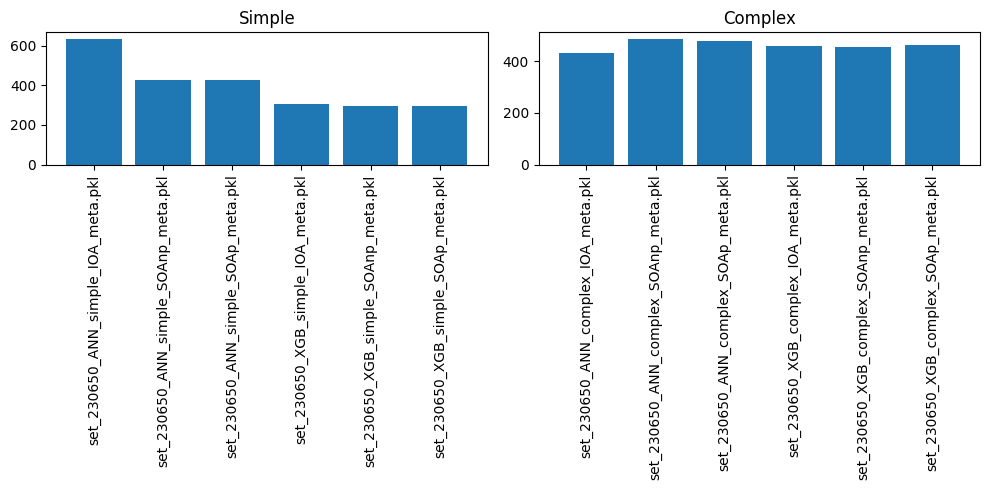

In [43]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('230650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('230650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['elapsed_time'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['elapsed_time'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\3351054437.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\3351054437.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


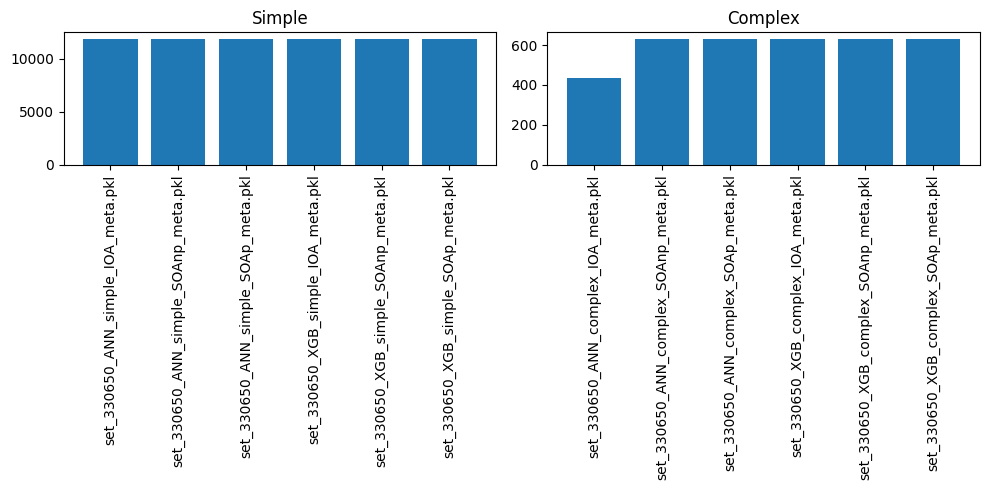

In [44]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('330650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('330650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['profit'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['profit'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2872324900.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2872324900.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


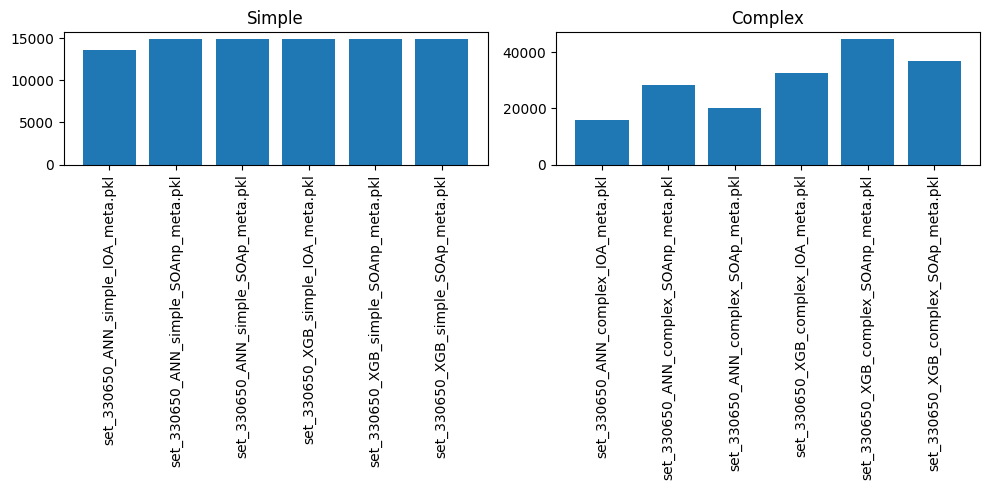

In [45]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('330650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('330650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['avg_memory'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['avg_memory'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2950979907.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2950979907.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


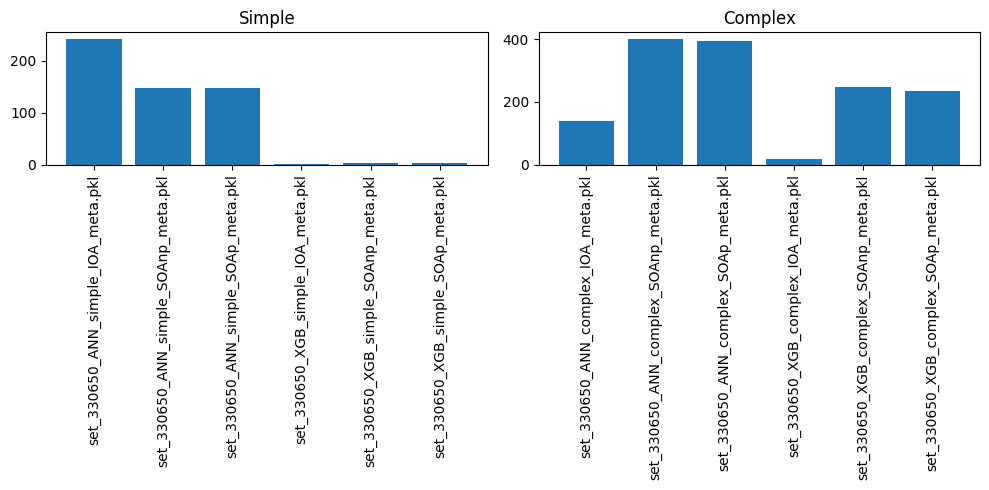

In [46]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('330650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('330650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['elapsed_time'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['elapsed_time'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2632565974.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2632565974.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


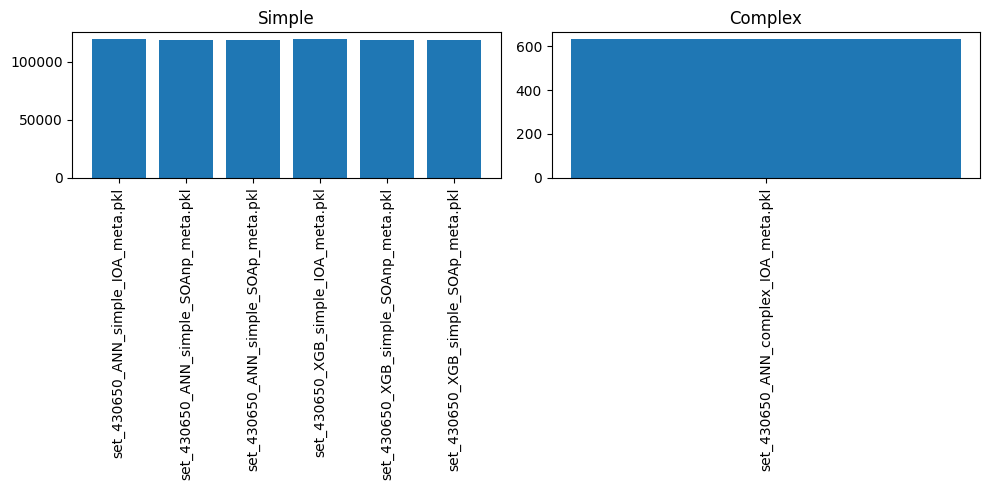

In [47]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('430650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('430650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['profit'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['profit'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2654305778.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\2654305778.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


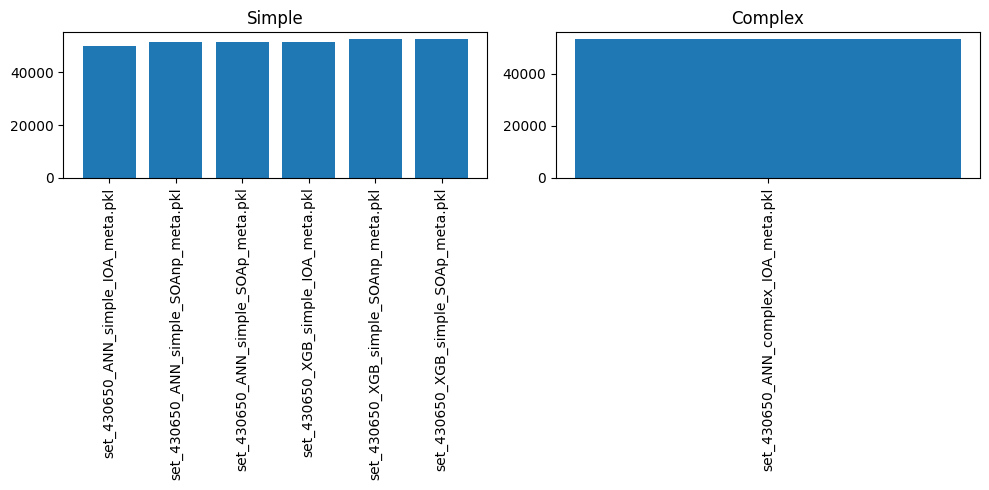

In [48]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('430650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('430650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['avg_memory'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['avg_memory'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\3319627109.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability
C:\Users\lanza\AppData\Local\Temp\ipykernel_9948\3319627109.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability


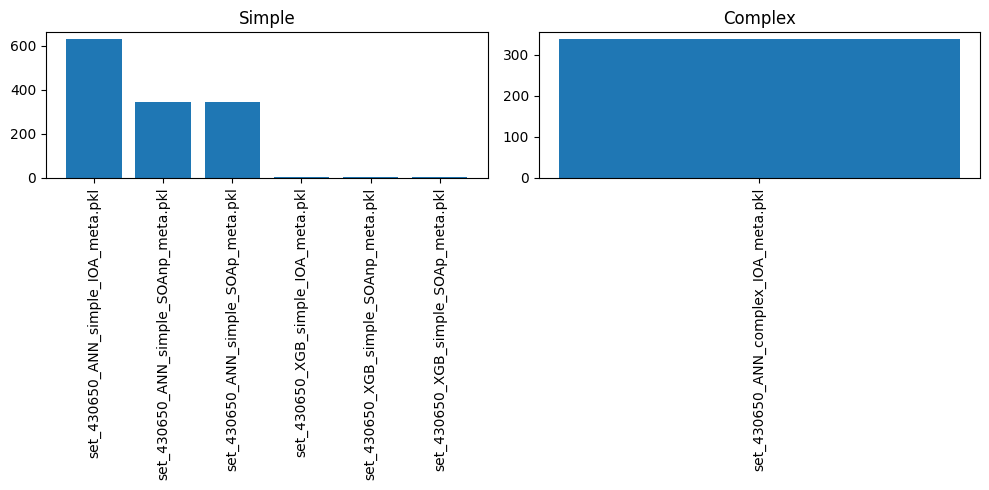

In [49]:
import matplotlib.pyplot as plt

# Split the DataFrame
df_simple = df_metadata[df_metadata['file_name'].str.contains('simple') & df_metadata['file_name'].str.contains('430650')]
df_complex = df_metadata[df_metadata['file_name'].str.contains('complex') & df_metadata['file_name'].str.contains('430650')]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'profit' column of df_simple
axs[0].bar(df_simple['file_name'], df_simple['elapsed_time'])
axs[0].set_title('Simple')
axs[0].set_xticklabels(df_simple['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Plot the 'profit' column of df_complex
axs[1].bar(df_complex['file_name'], df_complex['elapsed_time'])
axs[1].set_title('Complex')
axs[1].set_xticklabels(df_complex['file_name'], rotation=90)  # Rotate x-axis labels for readability

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [50]:
abc = df_metadata[['file_name', 'profit', 'avg_memory', 'peak_memory', 'elapsed_time']]
print(abc)

                                file_name         profit    avg_memory  \
0     set_130650_ANN_complex_IOA_meta.pkl     553.717783   4630.338927   
1   set_130650_ANN_complex_SOAnp_meta.pkl     589.402631  12534.661038   
2    set_130650_ANN_complex_SOAp_meta.pkl     537.520356   8322.597301   
3      set_130650_ANN_simple_IOA_meta.pkl    5699.049887   1724.434413   
4    set_130650_ANN_simple_SOAnp_meta.pkl    5488.522491   3566.640625   
5     set_130650_ANN_simple_SOAp_meta.pkl    2987.510813   3566.585938   
6     set_130650_XGB_complex_IOA_meta.pkl     633.393445   4882.388488   
7   set_130650_XGB_complex_SOAnp_meta.pkl     629.394780  20688.986769   
8    set_130650_XGB_complex_SOAp_meta.pkl     629.395071  16643.974462   
9      set_130650_XGB_simple_IOA_meta.pkl     115.755886   3185.966435   
10   set_130650_XGB_simple_SOAnp_meta.pkl    5883.230086   3589.990709   
11    set_130650_XGB_simple_SOAp_meta.pkl    5883.242454   3589.990709   
12    set_230650_ANN_complex_IOA_meta.

In [51]:
import pickle

# specify the path to the pickled file
save_path = "C:/Users/lanza/Master_Thesis_EL/Integrated-vs-Seperated-Master-Thesis/test"
file_path = save_path + "/dataset_list.pkl"

# load the data from the file
with open(file_path, 'rb') as f:
    dataset_list = pickle.load(f)

print(dataset_list)
print(len(dataset_list))
print(dataset_list[0]) 
print(dataset_list[0]['dataset_id'])

[{'dataset_id': 'set_130650', 'dataset_path': 'test//set_130650/set_130650_data.pkl', 'folder_path': 'test//set_130650'}, {'dataset_id': 'set_230650', 'dataset_path': 'test//set_230650/set_230650_data.pkl', 'folder_path': 'test//set_230650'}, {'dataset_id': 'set_330650', 'dataset_path': 'test//set_330650/set_330650_data.pkl', 'folder_path': 'test//set_330650'}]
3
{'dataset_id': 'set_130650', 'dataset_path': 'test//set_130650/set_130650_data.pkl', 'folder_path': 'test//set_130650'}
set_130650


In [52]:
# open dataset
import pickle

save_path = "C:/Users/lanza/Master_Thesis_EL/Integrated-vs-Seperated-Master-Thesis/test/set_330650"
file_path = save_path + "/set_330650_data.pkl"

# load the data from the file
with open(file_path, 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)


print(X_train[0:5, :])
print(y_train[0:5,:])


[[ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [-0.17799519  0.03441466  0.95637221]
 [-0.86259069 -1.4372086   0.37381424]
 [ 0.38147478 -0.26747454 -0.2828323 ]]
[[253. 252. 252. 253. 252. 252.]
 [252. 252. 252. 252. 252. 252.]
 [249. 251. 249. 254. 249. 253.]
 [240. 265. 251. 263. 240. 246.]
 [251. 246. 248. 251. 248. 242.]]


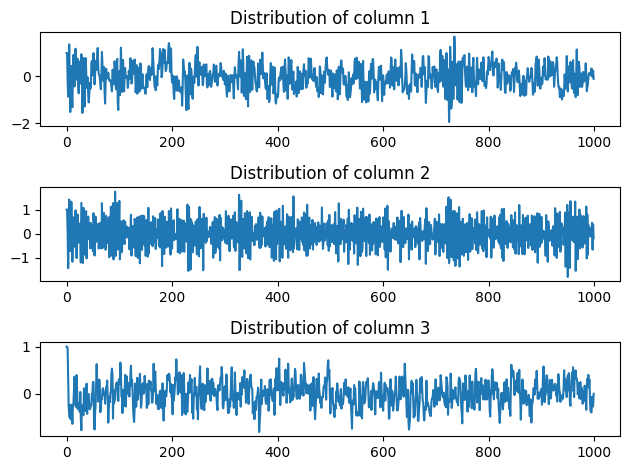

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Concatenate all X arrays
X_all = np.concatenate([X_train, X_val, X_test], axis=0)

# Create a figure and a set of subplots
fig, axs = plt.subplots(3)

# Plot the distribution of each column
for i in range(3):
    axs[i].plot(X_all[:, i])
    axs[i].set_title(f'Distribution of column {i+1}')

# Display the plot
plt.tight_layout()
plt.show()

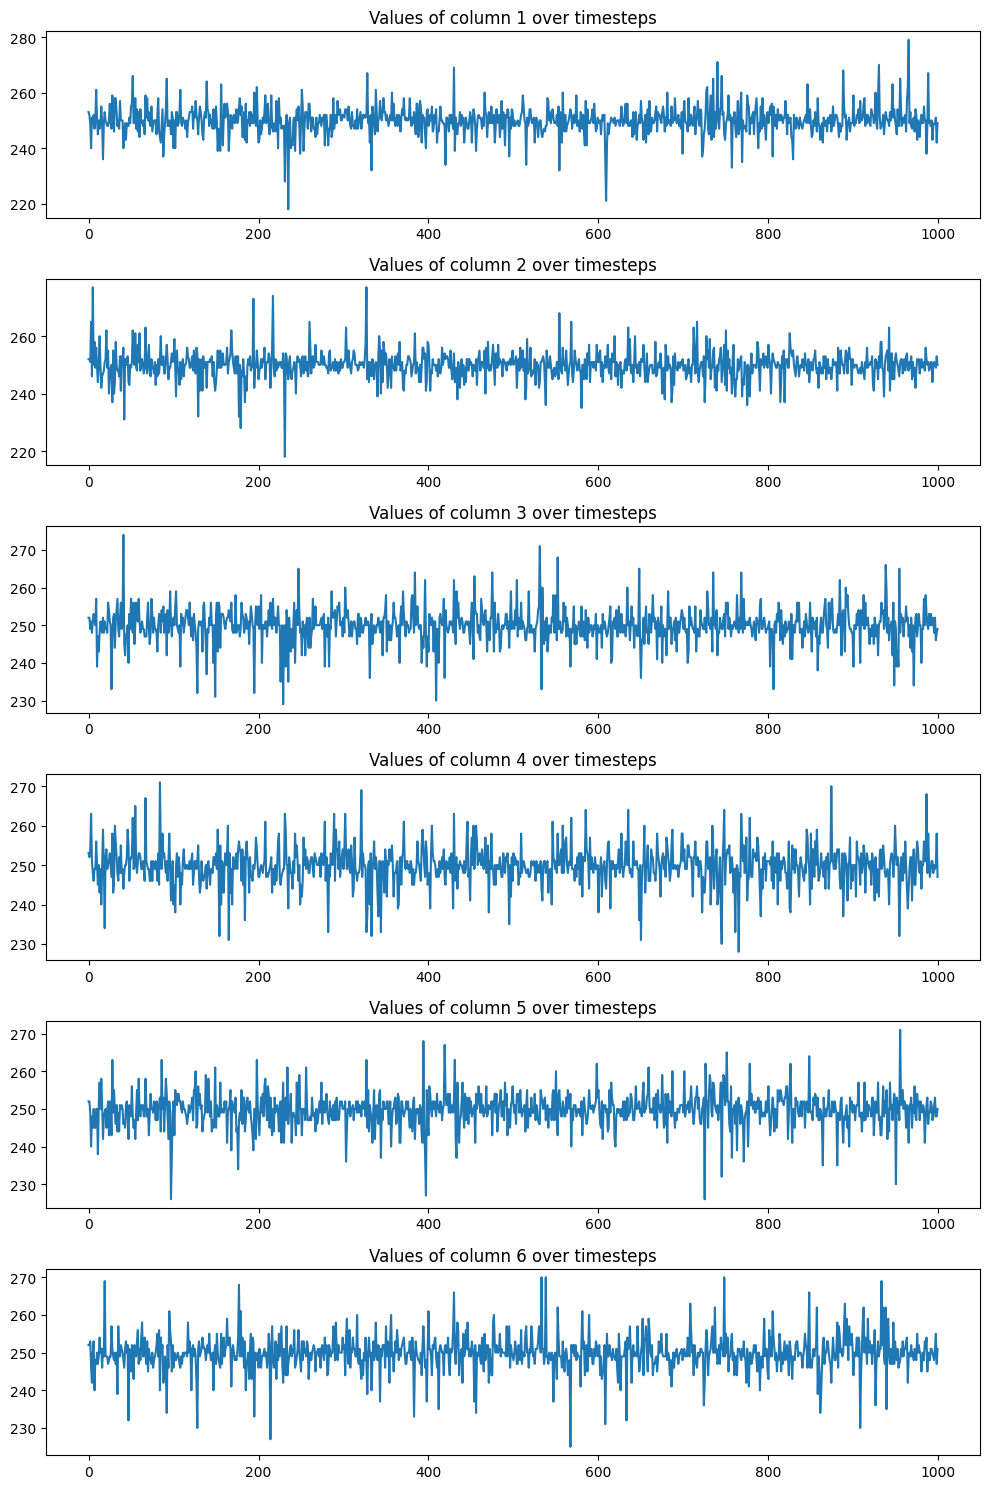

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Concatenate all y arrays
y_all = np.concatenate([y_train, y_val, y_test], axis=0)

# Create a figure and a set of subplots with a larger size
fig, axs = plt.subplots(y_all.shape[1], figsize=(10, 15))

# Plot the values of each column over the timesteps
for i in range(y_all.shape[1]):
    axs[i].plot(range(y_all.shape[0]), y_all[:, i])
    axs[i].set_title(f'Values of column {i+1} over timesteps')

# Display the plot
plt.tight_layout()
plt.show()